# Predictive Models 101: The Prediction Problem

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Chapter 17 | Notebook 1 of 3**

This notebook introduces predictive machine learning from a causal inference perspective,
emphasizing the distinction between prediction ($E[Y|X]$) and causal effects ($E[Y_1 - Y_0]$).

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

---

## 1. Intuition {#intuition}

### From Causal Effects to Predictions

In Part I of this book, we focused on **causal questions**:
- What is the average treatment effect? $E[Y_1 - Y_0]$
- Does the treatment cause the outcome?

Now we shift to **predictive questions**:
- Given features $X$, what outcome do we expect? $E[Y|X]$
- Can we forecast future values?

> **Key Distinction**: Prediction asks "what will happen?" while causation asks "what would happen if we intervene?"

### Machine Learning = Powerful Prediction

Machine learning is fundamentally about **estimating conditional expectations**:

$$\hat{f}(X) \approx E[Y|X]$$

The ML algorithm learns the mapping from inputs $X$ to outputs $Y$ by minimizing prediction error
on training data.

### Business Framing: Customer Profitability

Consider a customer acquisition problem:

1. **Cost of Acquisition (CAC)**: Marketing, onboarding, installation
2. **Revenue Stream**: Monthly payments, purchases
3. **Maintenance Costs**: Support, service
4. **Net Value**: Revenue - Costs

**The Prediction Problem**: Given customer features (age, region, income), predict their net value.

**The Business Decision**: Engage only with customers predicted to be profitable.

---

## 2. Formal Treatment {#formal}

### 2.1 Prediction vs Causation

| Aspect | Prediction | Causation |
|--------|------------|----------|
| Question | $E[Y|X]$ | $E[Y|do(T)]$ |
| Goal | Forecast | Intervention effect |
| Data need | $(X, Y)$ pairs | Exogenous variation |
| Confounding | Exploited | Controlled |
| Example | "What's this customer's value?" | "Will a discount increase purchases?" |

### 2.2 The ML Objective

Machine learning minimizes **expected loss** over the data distribution:

$$\hat{f} = \arg\min_f E_{X,Y}[L(Y, f(X))]$$

For regression with squared loss:

$$\hat{f} = \arg\min_f E[(Y - f(X))^2]$$

The solution is the **conditional expectation**:

$$\hat{f}(X) = E[Y|X]$$

This is why ML "learns" the conditional mean.

### 2.3 Bias-Variance Tradeoff

For any estimator $\hat{f}$, the expected squared error decomposes:

$$E[(Y - \hat{f}(X))^2] = \underbrace{\text{Bias}^2}_{\text{systematic error}} + \underbrace{\text{Variance}}_{\text{estimation noise}} + \underbrace{\sigma^2}_{\text{irreducible}}$$

Where:
- **Bias**: $E[\hat{f}(X)] - f(X)$ (wrong on average)
- **Variance**: $E[(\hat{f}(X) - E[\hat{f}(X)])^2]$ (sensitive to training data)

**The Tradeoff**:
- Simple models → High bias, low variance (underfitting)
- Complex models → Low bias, high variance (overfitting)

---

## 3. Numeric Demonstration {#numeric}

### Customer Data

In [2]:
# Load transaction data
transactions = load_facure_data("customer_transactions.csv")
print(f"Transaction data shape: {transactions.shape}")
print(f"Columns: {transactions.columns[:5].tolist()} ... (30 days of transactions)")

Transaction data shape: (10000, 32)
Columns: ['customer_id', 'cacq', 'day_0', 'day_1', 'day_2'] ... (30 days of transactions)


In [3]:
# Compute net value per customer
profitable = transactions[['customer_id']].assign(
    net_value=transactions.drop(columns='customer_id').sum(axis=1)
)

# Load customer features and merge
customer_features = load_facure_data("customer_features.csv").merge(
    profitable, on='customer_id'
)

print(f"Customer features shape: {customer_features.shape}")
customer_features.head()

Customer features shape: (10000, 5)


,customer_id,region,income,age,net_value
0,0,30,1025,24,130
1,1,41,1649,26,10
2,2,18,2034,33,-6
3,3,20,1859,35,136
4,4,1,1243,26,-8


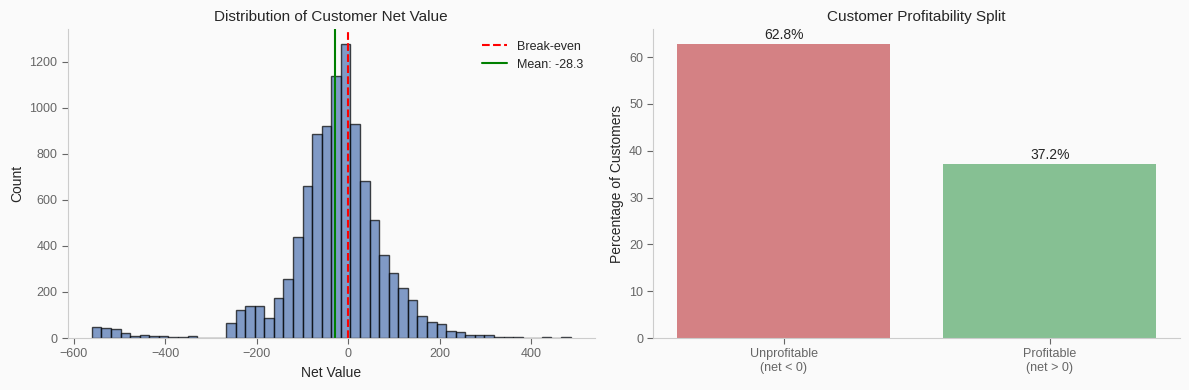

Average net value: -28.27
Profitable customers: 37.2%


In [4]:
# Distribution of net value
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
ax = axes[0]
ax.hist(customer_features['net_value'], bins=50, color=COLORS['blue'], alpha=0.7, edgecolor='black')
ax.axvline(0, color='red', linestyle='--', label='Break-even')
ax.axvline(customer_features['net_value'].mean(), color='green', linestyle='-', 
           label=f"Mean: {customer_features['net_value'].mean():.1f}")
ax.set_xlabel('Net Value')
ax.set_ylabel('Count')
ax.set_title('Distribution of Customer Net Value')
ax.legend()
apply_tufte_style(ax)

# Profitable vs unprofitable
ax = axes[1]
profitable_pct = (customer_features['net_value'] > 0).mean() * 100
ax.bar(['Unprofitable\n(net < 0)', 'Profitable\n(net > 0)'], 
       [100 - profitable_pct, profitable_pct],
       color=[COLORS['red'], COLORS['green']], alpha=0.7)
ax.set_ylabel('Percentage of Customers')
ax.set_title('Customer Profitability Split')
for i, v in enumerate([100 - profitable_pct, profitable_pct]):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center')
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

print(f"Average net value: {customer_features['net_value'].mean():.2f}")
print(f"Profitable customers: {profitable_pct:.1f}%")

### The Naive Policy: Engage Everyone

If average net value is negative, engaging with all customers loses money.

In [5]:
# Split into train/test
train, test = train_test_split(customer_features, test_size=0.3, random_state=13)

print(f"Training set: {train.shape[0]} customers")
print(f"Test set: {test.shape[0]} customers")
print(f"\nTraining set average net value: {train['net_value'].mean():.2f}")
print(f"Test set average net value: {test['net_value'].mean():.2f}")

if train['net_value'].mean() < 0:
    print("\n>>> Engaging with ALL customers would lose money on average!")

Training set: 7000 customers
Test set: 3000 customers

Training set average net value: -29.17
Test set average net value: -26.18

>>> Engaging with ALL customers would lose money on average!


### Single-Feature Exploration

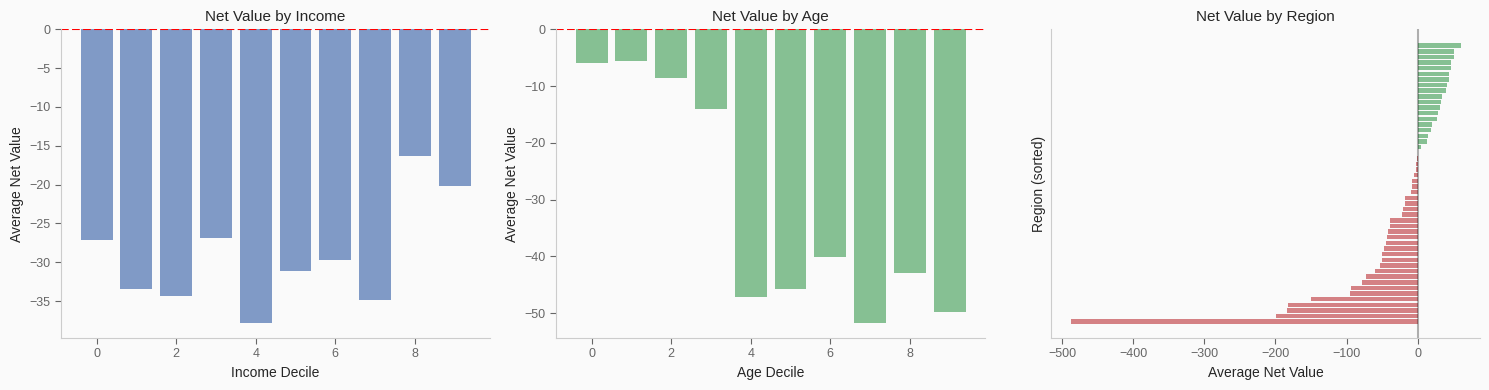

Profitable regions: 20 / 50


In [6]:
# Explore net value by features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# By income quantile
ax = axes[0]
train_income = train.assign(income_q=pd.qcut(train['income'], q=10, labels=False))
income_means = train_income.groupby('income_q')['net_value'].mean()
ax.bar(income_means.index, income_means.values, color=COLORS['blue'], alpha=0.7)
ax.axhline(0, color='red', linestyle='--')
ax.set_xlabel('Income Decile')
ax.set_ylabel('Average Net Value')
ax.set_title('Net Value by Income')
apply_tufte_style(ax)

# By age quantile
ax = axes[1]
train_age = train.assign(age_q=pd.qcut(train['age'], q=10, labels=False, duplicates='drop'))
age_means = train_age.groupby('age_q')['net_value'].mean()
ax.bar(age_means.index, age_means.values, color=COLORS['green'], alpha=0.7)
ax.axhline(0, color='red', linestyle='--')
ax.set_xlabel('Age Decile')
ax.set_ylabel('Average Net Value')
ax.set_title('Net Value by Age')
apply_tufte_style(ax)

# By region (top 20)
ax = axes[2]
region_means = train.groupby('region')['net_value'].mean().sort_values()
colors = [COLORS['green'] if v > 0 else COLORS['red'] for v in region_means.values]
ax.barh(range(len(region_means)), region_means.values, color=colors, alpha=0.7)
ax.axvline(0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Average Net Value')
ax.set_ylabel('Region (sorted)')
ax.set_title('Net Value by Region')
ax.set_yticks([])
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

# Count profitable regions
n_profitable_regions = (region_means > 0).sum()
print(f"Profitable regions: {n_profitable_regions} / {len(region_means)}")

### Key Insight: Region Matters Most

Some regions have positive average net value while income/age alone don't separate
profitable from unprofitable customers.

```
★ Insight ─────────────────────────────────────────────────────
Before building complex ML models, explore single features.
Often, simple rules (like "only engage in certain regions")
capture most of the predictive value.

This is the 80/20 rule applied to ML.
──────────────────────────────────────────────────────────────
```

---

## 4. Implementation {#implementation}

### Region-Based Policy

In [7]:
# Build region policy from training data
region_stats = train.groupby('region')['net_value'].agg(['mean', 'count', 'std'])
region_stats['lower_bound'] = (
    region_stats['mean'] - 1.96 * region_stats['std'] / np.sqrt(region_stats['count'])
)

# Regions where lower bound of 95% CI > 0
profitable_regions = region_stats[region_stats['lower_bound'] > 0].index.tolist()

print(f"Profitable regions (95% CI lower bound > 0): {len(profitable_regions)}")
print(f"Regions: {profitable_regions[:10]}..." if len(profitable_regions) > 10 else f"Regions: {profitable_regions}")

Profitable regions (95% CI lower bound > 0): 18
Regions: [1, 2, 4, 9, 11, 12, 15, 17, 18, 19]...


In [8]:
# Evaluate region policy on test set
test_region_policy = test[test['region'].isin(profitable_regions)]

# Total value if we engage with EVERYONE in test
total_value_all = test['net_value'].sum()

# Total value with region policy
total_value_region = test_region_policy['net_value'].sum()

# Per-customer value
per_customer_all = test['net_value'].mean()
per_customer_region = total_value_region / len(test)  # Normalize by total customers

print(f"Test Set Evaluation:")
print(f"  Engage ALL: {per_customer_all:.2f} per customer (total: {total_value_all:,.0f})")
print(f"  Region Policy: {per_customer_region:.2f} per customer (total: {total_value_region:,.0f})")
print(f"\nImprovement: {per_customer_region - per_customer_all:.2f} per customer")

Test Set Evaluation:
  Engage ALL: -26.18 per customer (total: -78,526)
  Region Policy: 15.57 per customer (total: 46,712)

Improvement: 41.75 per customer


### The Need for ML

The region policy works, but:
1. We only used ONE feature
2. Interactions (high income in marginal regions) are ignored
3. Manual exploration doesn't scale to 100+ features

ML automates this by learning $E[Y|X_1, X_2, ..., X_p]$ jointly.

---

## 5. Interview Appendix {#interview}

### Q1: What's the difference between prediction and causal inference?

<details>
<summary>Solution</summary>

**Key points:**

1. **Prediction** estimates $E[Y|X]$ - what we expect given observed features
   - Can use ANY correlated features, including confounders
   - Goal: minimize forecast error

2. **Causal inference** estimates $E[Y|do(T)]$ - what happens if we intervene
   - Must account for confounding
   - Goal: identify intervention effect

3. **Example**: Umbrella sales predict rain (correlation), but buying umbrellas
   doesn't cause rain (no causal effect).

4. **When prediction ≠ causation**:
   - Confounders boost prediction but bias causal estimates
   - Post-treatment variables good for prediction, bad for causation

</details>

### Q2: Why is the conditional expectation the optimal predictor under squared loss?

<details>
<summary>Solution</summary>

**Key points:**

1. **Setup**: Minimize $E[(Y - f(X))^2]$ over all functions $f$

2. **Derivation**:
   - Take derivative w.r.t. $f(x)$: $-2E[Y - f(X)|X=x] = 0$
   - Solve: $f(x) = E[Y|X=x]$

3. **Intuition**: The conditional mean minimizes average squared distance
   to all possible $Y$ values at each $X$.

4. **For other losses**:
   - Absolute loss → conditional median
   - 0-1 loss → conditional mode

</details>

### Q3: When should you use a simple single-feature policy vs ML?

<details>
<summary>Solution</summary>

**Prefer simple policies when:**
- Few features with clear predictive power
- Interpretability is critical
- Data is limited (ML overfits)
- Quick deployment needed

**Prefer ML when:**
- Many features with complex interactions
- Large dataset available
- Marginal gains are worth the complexity
- Prediction accuracy is paramount

**Always start simple**: The 80/20 rule applies to ML.

</details>

---

## 6. References {#references}

[^1]: Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning*.

[^2]: Mullainathan, S., & Spiess, J. (2017). Machine Learning: An Applied Econometric Approach.
      *Journal of Economic Perspectives*, 31(2), 87-106.

[^3]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 17.